In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt

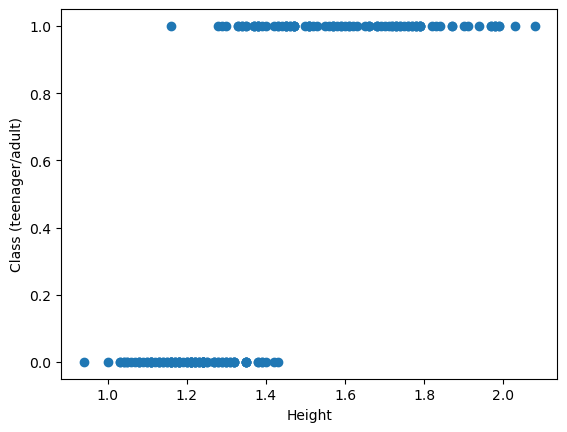

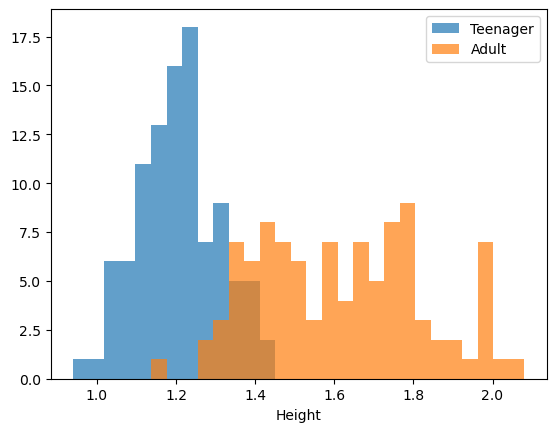

In [4]:
data = torch.from_numpy(np.loadtxt('../data/age_data_3.txt'))
x, targets = data.T

plt.scatter(x, targets)
plt.xlabel('Height')
plt.ylabel('Class (teenager/adult)')

bins = np.linspace(x.min(), x.max(), 30)
plt.figure()
plt.hist(x[targets==0], bins, alpha=0.7)
plt.hist(x[targets==1], bins, alpha=0.7)
plt.xlabel('Height')
plt.legend(('Teenager', 'Adult'))

In [5]:
x

tensor([1.3800, 1.2400, 1.3000, 1.4200, 1.3900, 1.1000, 1.3000, 1.1800, 1.1900,
        1.2400, 1.2100, 1.3500, 1.2800, 1.2100, 1.2400, 1.2300, 1.3500, 1.1800,
        1.2300, 1.1100, 0.9400, 1.2700, 1.2900, 1.1300, 1.4300, 1.0500, 1.2000,
        1.1800, 1.3500, 1.3500, 1.2200, 1.2400, 1.1100, 1.0000, 1.1700, 1.2200,
        1.3200, 1.3200, 1.1600, 1.1700, 1.1000, 1.0600, 1.0300, 1.4000, 1.1500,
        1.1600, 1.0700, 1.2800, 1.0400, 1.1800, 1.1100, 1.2400, 1.1500, 1.0800,
        1.2000, 1.2400, 1.2100, 1.2300, 1.1400, 1.1600, 1.1300, 1.1600, 1.1200,
        1.0300, 1.2200, 1.1600, 1.0400, 1.2500, 1.1100, 1.2100, 1.2700, 1.2100,
        1.3100, 1.0800, 1.2400, 1.1300, 1.1100, 1.1400, 1.1700, 1.2100, 1.0800,
        1.2900, 1.2500, 1.0500, 1.3500, 1.3900, 1.3200, 1.1800, 1.0900, 1.3100,
        1.1600, 1.3200, 1.2200, 1.3000, 1.2400, 1.2700, 1.2000, 1.3800, 1.2100,
        1.2400, 1.9800, 1.3300, 1.3500, 1.7900, 1.3700, 1.9900, 1.5200, 1.4500,
        1.9800, 1.9000, 1.9700, 1.7800, 

Text(0, 0.5, 'P(Adult|Height)')

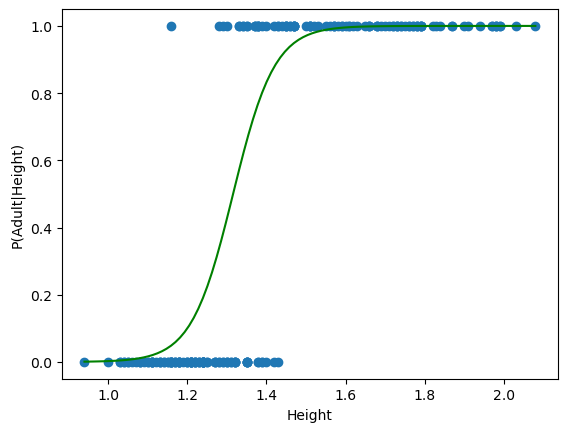

In [6]:
class Model:

    def __init__(self, a, b, requires_grad=False):

        # Parâmetros do modelo
        self.a = torch.tensor(a, requires_grad=requires_grad)
        self.b = torch.tensor(b, requires_grad=requires_grad)

    def __call__(self, x):
        y = self.a*x + self.b
        return  y
    
    def parameters(self):
        """Retorna os parâmetros do modelo."""
        return self.a, self.b

    def zero_grad(self):
        """Remove os gradientes anteriormente calculados."""
        for p in self.parameters():
            p.grad = None    
    
def sigmoid(x):
    """Recebe um valor qualquer e transforma ele para o intervalo [0,1]."""
    y = 1/(1+torch.exp(-x))
    return y

model = Model(19., -25.)
scores = model(x)
# Probabilidade de cada pessoa ser adulta
probs = sigmoid(scores)

# Cálculo das probabilidades para todas as possíveis entradas x
inputsm = torch.linspace(x.min(), x.max(), 100)
scoresm = model(inputsm)
probsm = sigmoid(scoresm)

plt.scatter(x, targets)
plt.plot(inputsm, probsm, c='g')
plt.xlabel('Height')
plt.ylabel('P(Adult|Height)')


Acurácia

In [7]:
def accuracy(preds, targets):
    return torch.sum((preds==targets))/len(preds)
    
preds = probs>0.5
accuracy(preds, targets)
    

tensor(0.9000)

### Função de Likelihood (verossimilhança) e entropia cruzada
Probabilidade de gerar a classe

In [8]:
def prob_of_target(probs, targets):
    # n = len(probs)
    # probs_target = torch.zero(n)
    # for idx in range(n):
    #     prob, target = probs[idx], targets[idx]
    #     if target==0:
    #         # probabilidade de ser da classe 0 
    #         probs_target[idx] = 1-prob 
    #     else:
    #         # probabilidade de ser da classe 1
    #         probs_target[idx] = prob
    return probs*targets+(1-probs)*(1-targets)

# A função perfeita retorna likelihood = 1 (produto entre 1's)
def likelihood(probs, targets):
    probs_correct = prob_of_target(probs,targets)
    return torch.prod(probs_correct)
        
print(likelihood(probs,targets))

tensor(2.2591e-20, dtype=torch.float64)


Produto de probabilidades tende a ser um número muito pequeno devido à multiplicações de números <1.

Para ressolver isso, há o negative-log-likelihood.

No melhor caso, o NLL é 0 (log 1)


In [9]:
def nll(probs, targets):
    """Negative log-likelihood"""
    probs_correct = prob_of_target(probs, targets)
    probs_log = torch.log(probs_correct)
    
    return - torch.sum(probs_log)

print(nll(probs,targets))

tensor(45.2367, dtype=torch.float64)


### Entropia cruzada (Cross Entropy)

Para o modelo ideal:

* Quando o item é da classe 0, o modelo tem como resultado P(c=0|x)=1

* Quando o item é da classe 1, o modelo tem como resultado P(c=1|x)=1

A entropia cruzada quantifica o quão similar a saída do modelo é em relação ao valor [1,0] (para a classe 0) e [0,1] (para a classe 1).

Utilizada principalmente para multiclass (**TORCH.NN.FUNCTIONAL.CROSS_ENTROPY**)

In [10]:
def cross_entropy(scores, targets):
    probs = sigmoid(scores)
    probs_correct = prob_of_target(probs, targets)
    probs_log = torch.log(probs_correct)
    
    return -torch.mean(probs_log)

print(cross_entropy(scores, targets))

tensor(0.2262, dtype=torch.float64)


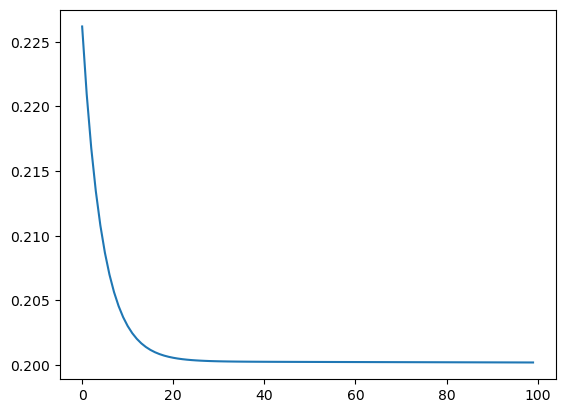

In [14]:
def step(mode, x, targets, lr):
    model.zero_grad()
    scores = model(x)
    loss = cross_entropy(scores, targets)
    loss.backward()
    
    with torch.no_grad():
        for p in model.parameters():
            p -= lr*p.grad
    return loss.item()


model = Model(19., -25., requires_grad=True)
num_epochs = 100
lr = 0.5
losses = []
for epoch in range(num_epochs):
    loss = step(model, x, targets, lr)
    losses.append(loss)
plt.plot(losses)